# Feature Engineering & Machine Learning with Snowpark
### Objectif : 
Trouver parmis une liste d'annonces immobiliéres les biens en ventes les plus rentables pour un investissement locatif
### Données en entrée : 
Tables Snowflake contenant des annonces immobiliéres de ventes et de location  
### Etapes permettant d'atteindre l'objectif : 
![title](img/UC.png)




# C'est parti !!!!

#### Connexion à Snowflake 

In [1]:
import json

import numpy as np
import pandas as pd
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Session
from snowflake.snowpark.types import PandasDataFrame, PandasSeries

with open("CredsOregon.json") as f:
    connection_parameters = json.load(f)

mySnowSess = Session.builder.configs(connection_parameters).create()

In [ ]:
realestate_kpi_df = realestate_df.select(
    F.col("ADS_ID"), F.col("ADS_SQUARE"), F.col("ADS_ROOMS"), F.col("ADS_PRICE")
).agg(
    [
        F.count(F.col("ADS_ID")).as_("COUNT_ADS"),
        F.median(F.col("ADS_PRICE")).cast(T.IntegerType()).as_("MED_PRICE"),
        F.median(F.col("ADS_SQUARE")).cast(T.IntegerType()).as_("MED_SQUARE"),
        (F.median(F.col("ADS_PRICE") / F.col("ADS_SQUARE")))
        .cast(T.IntegerType())
        .as_("MED_PRICE_SQUARE"),
        F.median(F.col("ADS_ROOMS")).cast(T.IntegerType()).as_("MED_ROOM"),
    ]
)

# Préparation des données
![title](img/UC_1.png)

In [2]:
SnowDataFrame_Annonces_RawJSON = mySnowSess.table(
    "PETITES_ANNONCES_IMMOBILIRES.PUBLIC.LBC_ADS_JSON_DT"
)

In [3]:
SnowDataFrame_Annonces_RawJSON.limit(1).show()

------------------------------------------------------
|"ADS"                                               |
------------------------------------------------------
|{                                                   |
|  "attribute": {                                    |
|    "available_date": {                             |
|      "generic": true,                              |
|      "value": "03/2024",                           |
|      "value_label": "03/2024",                     |
|      "values": [                                   |
|        "03/2024"                                   |
|      ]                                             |
|    },                                              |
|    "bedrooms": {                                   |
|      "generic": true,                              |
|      "value": "1",                                 |
|      "value_label": "1 ch.",                       |
|      "values": [                                   |
|        "

In [4]:
SnowDataFrame_Annonces_Location_Raw = (
    SnowDataFrame_Annonces_RawJSON
    .filter((F.col("ADS")["category_name"].cast(T.StringType()) == "Locations")
          & (F.col("ADS")["first_publication_date"].cast(T.TimestampType()) > F.current_date()-365))
    .select(
        F.col("ADS")["list_id"].cast(T.IntegerType()).as_("ADS_id"),
        F.col("ADS")["index_date"].cast(T.TimestampType()).as_("ADS_Index_Date"),
        F.col("ADS")["first_publication_date"].cast(T.TimestampType()).as_("ADS_First_Publication_Date"),
        F.col("ADS")["price"].cast(T.IntegerType()).as_("ADS_Price"),
        F.col("ADS")["location"]["city"].cast(T.StringType()).as_("ADS_Geo_City"),
        F.col("ADS")["location"]["zipcode"].cast(T.StringType()).as_("ADS_Geo_ZipCode"),
        F.col("ADS")["location"]["lat"].cast(T.DoubleType()).as_("ADS_Geo_Lat"),
        F.col("ADS")["location"]["lng"].cast(T.DoubleType()).as_("ADS_Geo_Lng"),
        F.col("ADS")["real_estate_type"].cast(T.StringType()).as_("ADS_Attr_Real_estate_type"),
        F.col("ADS")["rooms"].cast(T.IntegerType()).as_("ADS_Attr_Rooms"),
        F.col("ADS")["square"].cast(T.IntegerType()).as_("ADS_Attr_Square"),
        F.col("ADS")["attribute"]["ges"]["value_label"].cast(T.StringType()).as_("ADS_Attr_GES"),
        F.col("ADS")["attribute"]["energy_rate"]["value_label"].cast(T.StringType()).as_("ADS_Attr_Energy_Rate"),
    )
    .orderBy(F.col("ADS_id"), F.col("ADS_Index_Date").desc())
)

In [5]:
SnowDataFrame_Annonces_Location_Raw.limit(100).to_pandas()

,ADS_ID,ADS_INDEX_DATE,ADS_FIRST_PUBLICATION_DATE,ADS_PRICE,ADS_GEO_CITY,ADS_GEO_ZIPCODE,ADS_GEO_LAT,ADS_GEO_LNG,ADS_ATTR_REAL_ESTATE_TYPE,ADS_ATTR_ROOMS,ADS_ATTR_SQUARE,ADS_ATTR_GES,ADS_ATTR_ENERGY_RATE
0,450034853,2024-03-27 08:43:16,2024-03-27 08:43:16,480,Valenciennes (59),59300,50.35141,3.51471,Appartement,2,45,D,D
1,612962662,2024-03-28 10:19:19,2024-03-22 11:48:00,545,Orvault (44),44700,47.27093,-1.62314,Appartement,1,28,B,B
2,627055591,2024-03-15 16:26:46,2024-03-15 16:26:46,530,Chartres (28),28000,48.44452,1.48341,Appartement,1,28,B,B
3,662835207,2024-03-28 10:19:19,2024-03-15 16:27:54,485,Carquefou (44),44470,47.29751,-1.49181,Appartement,1,28,B,B
4,719997079,2024-03-02 20:52:14,2024-03-02 20:52:14,1600,Antibes (06),06600,43.58195,7.12213,Appartement,3,60,A,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1676193132,2023-11-27 13:28:26,2023-11-27 13:28:26,650,Hirson (02),02500,49.92294,4.08146,Appartement,4,140,Vierge,Vierge
96,1676636231,2024-02-20 22:54:01,2024-02-20 22:54:01,490,Hyères (83),83400,43.06561,6.14897,Appartement,1,21,Non renseigné,Non renseigné
97,1681428983,2024-03-15 16:26:38,2024-03-15 16:26:38,450,Tours (37),37000,47.38846,0.68957,Appartement,1,27,B,B
98,1683181258,2024-03-22 11:32:37,2024-03-22 11:32:37,505,Saint-Malo (35),35400,48.65058,-2.02315,Appartement,1,28,B,B


![title](img/UC_2.png)


### On calcule le prix / m2 median pour chaque ville

In [6]:
SnowDataFrame_PrixM2_Median = (
    SnowDataFrame_Annonces_Location_Raw.select(
        F.col("ADS_GEO_ZIPCODE"),
        F.col("ADS_GEO_CITY"),
        (F.col("ADS_PRICE") / F.col("ADS_ATTR_SQUARE")).as_("ADS_PRICE_SQUARE"),
    )
    .groupBy(
        F.col("ADS_GEO_ZIPCODE"),
        F.col("ADS_GEO_CITY"),
    )
    .agg(
        [
            F.median(F.col("ADS_PRICE_SQUARE")).as_("MED_PRICE"),
        ]
    )
)

### On associe le prix median à chaque annonce (Join)

In [7]:
SnowDataFrame_AnnLoc_PrixM2_Median = SnowDataFrame_Annonces_Location_Raw.join(
    SnowDataFrame_PrixM2_Median,
    (
        SnowDataFrame_Annonces_Location_Raw.col("ADS_GEO_ZIPCODE")
        == SnowDataFrame_PrixM2_Median.col("ADS_GEO_ZIPCODE")
    )
    & (
        SnowDataFrame_Annonces_Location_Raw.col("ADS_GEO_CITY")
        == SnowDataFrame_PrixM2_Median.col("ADS_GEO_CITY")
    ),
)

### On filtre les données 

In [8]:
SnowDataFrame_AnnLoc_SansOutlier = (
    SnowDataFrame_AnnLoc_PrixM2_Median.withColumn(
        "ADS_PRICE_SQUARE", F.col("ADS_PRICE") / F.col("ADS_ATTR_SQUARE")
    )
    .filter(
        (
            F.col("ADS_PRICE_SQUARE") / (F.col("ADS_PRICE_SQUARE") + F.col("MED_PRICE"))
            >= 0.3
        )
        & (
            F.col("ADS_PRICE_SQUARE") / (F.col("ADS_PRICE_SQUARE") + F.col("MED_PRICE"))
            < 0.7
        )
        & (F.col("ADS_PRICE_SQUARE") < 150)
        & (F.col("ADS_PRICE_SQUARE") > 0)
        & (F.col("ADS_ATTR_SQUARE") >= 9)
        & (F.col("ADS_ATTR_SQUARE") <= 300)
        & (F.not_(F.is_null(F.col("ADS_ATTR_ENERGY_RATE"))))
    )
    .select(
        F.col("ADS_GEO_LAT"),
        F.col("ADS_GEO_LNG"),
        F.col("ADS_ATTR_ROOMS"),
        F.col("ADS_ATTR_SQUARE"),
        F.col("ADS_ATTR_REAL_ESTATE_TYPE"),
        F.col("ADS_ATTR_ENERGY_RATE"),
        F.col("ADS_PRICE"),
    )
)

In [9]:
SnowDataFrame_AnnLoc_SansOutlier.select(F.count("*")).show()

--------------
|"COUNT(1)"  |
--------------
|951656      |
--------------



In [10]:
SnowDataFrame_AnnLoc_SansOutlier.limit(10).to_pandas()

,ADS_GEO_LAT,ADS_GEO_LNG,ADS_ATTR_ROOMS,ADS_ATTR_SQUARE,ADS_ATTR_REAL_ESTATE_TYPE,ADS_ATTR_ENERGY_RATE,ADS_PRICE
0,50.35141,3.51471,2,45,Appartement,D,480
1,47.27093,-1.62314,1,28,Appartement,B,545
2,48.44452,1.48341,1,28,Appartement,B,530
3,47.29751,-1.49181,1,28,Appartement,B,485
4,43.58195,7.12213,3,60,Appartement,B,1600
5,48.95130,7.64264,3,70,Appartement,Non renseigné,800
6,47.82859,1.97162,2,20,Appartement,D,396
7,45.24085,4.67219,2,27,Appartement,E,360
8,48.62468,2.42977,2,40,Appartement,B,715
9,48.06064,-3.41078,5,90,Maison,Non renseigné,800


![title](img/UC_3.png)

### On définit une fonction pour encoder le type de bien 

In [11]:
@F.pandas_udf(
    name="UDF_Encode_TypeDeBien_Snow",
    is_permanent=True,
    stage_location="@UDF_PACKAGE_STAGE",
    replace=True,
    max_batch_size=5000,
)
def UDF_Encode_TypeDeBien(
    x: PandasSeries[str],
) -> PandasSeries[int]:
    return x.apply(
        lambda val: 2 if val == "Maison" else 1 if val == "Appartement" else 0
    )

### On définit une fonction pour encoder la classe énergie 

In [12]:
from sklearn import preprocessing

ADS_ATTR_ENERGY_RATE_List = np.array(
    SnowDataFrame_Annonces_RawJSON.select(
        F.col("ADS")["attribute"]["energy_rate"]["value_label"]
        .cast(T.StringType())
        .as_("ADS_ATTR_ENERGY_RATE_NUM")
    )
    .distinct()
    .dropna()
    .orderBy(F.col("ADS_ATTR_ENERGY_RATE_NUM").asc())
    .collect()
).flat

le = preprocessing.LabelEncoder()
le.fit(ADS_ATTR_ENERGY_RATE_List)

dep_packages = ["scikit-learn"]


@F.pandas_udf(
    name="UDF_Encode_ClasseEnergie",
    packages=dep_packages,
    is_permanent=True,
    stage_location="@UDF_PACKAGE_STAGE",
    replace=True,
    max_batch_size=1000,
)
def UDF_Encode_ClasseEnergie(
    x: PandasSeries[str],
) -> PandasSeries[int]:
    return le.transform(x)

In [13]:
SnowDataFrame_AnnLoc_PourEntrainement = SnowDataFrame_AnnLoc_SansOutlier.select(
    F.col("ADS_GEO_LAT"),
    F.col("ADS_GEO_LNG"),
    F.col("ADS_ATTR_ROOMS"),
    F.col("ADS_ATTR_SQUARE"),
    UDF_Encode_TypeDeBien(F.col("ADS_ATTR_REAL_ESTATE_TYPE")).as_(
        "ADS_ATTR_REAL_ESTATE_TYPE_NUM"
    ),
    UDF_Encode_ClasseEnergie(F.col("ADS_ATTR_ENERGY_RATE")).as_(
        "ADS_ATTR_ENERGY_RATE_NUM"
    ),
    F.col("ADS_PRICE"),
)
SnowDataFrame_AnnLoc_PourEntrainement.limit(10).to_pandas()


,ADS_GEO_LAT,ADS_GEO_LNG,ADS_ATTR_ROOMS,ADS_ATTR_SQUARE,ADS_ATTR_REAL_ESTATE_TYPE_NUM,ADS_ATTR_ENERGY_RATE_NUM,ADS_PRICE
0,50.35141,3.51471,2,45,1,3,480
1,47.27093,-1.62314,1,28,1,1,545
2,48.44452,1.48341,1,28,1,1,530
3,47.29751,-1.49181,1,28,1,1,485
4,43.58195,7.12213,3,60,1,1,1600
5,49.23522,2.97943,3,45,1,4,680
6,46.98886,3.15681,2,30,1,3,430
7,45.44124,4.38287,3,55,1,3,510
8,44.74173,-0.68569,2,47,1,2,750
9,43.48285,-1.55882,2,50,1,2,900


![title](img/UC_4.png)

### Création du jeu de données d'entrainement et de test (sklearn)

In [14]:
CollectedDataframe = SnowDataFrame_AnnLoc_PourEntrainement.to_pandas()

target = "ADS_PRICE"
predictors = [
    "ADS_GEO_LAT",
    "ADS_GEO_LNG",
    "ADS_ATTR_ROOMS",
    "ADS_ATTR_SQUARE",
    "ADS_ATTR_REAL_ESTATE_TYPE_NUM",
    "ADS_ATTR_ENERGY_RATE_NUM",
]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    CollectedDataframe[predictors], CollectedDataframe[target], test_size=0.2
)

import xgboost as xgb

DMatrix_train = xgb.DMatrix(X_train, label=y_train)
DMatrix_test = xgb.DMatrix(X_test, label=y_test)

### On entraine le modèle en utilisant XGBoost

In [15]:
param = {}
param["booster"] = "gbtree"
param["objective"] = "reg:squarederror"
param["max_depth"] = 10
param["eta"] = 0.5
param["max_delta_step"] = 0
param["alpha"] = 0
param["lambda"] = 1
param["gamma"] = 0
param["min_child_weight"] = 2.75
param["subsample"] = 0.75
param["colsample_bytree"] = 1
param["colsample_bylevel"] = 1
param["scale_pos_weight"] = 1
param["nthread"] = -1
param["verbosity"] = 1

evallist = [(DMatrix_train, "train"), (DMatrix_test, "eval")]
num_round = 50
bst = xgb.train(param, DMatrix_train, num_round, evallist, early_stopping_rounds=4)

[0]	train-rmse:445.57452	eval-rmse:446.19907
[1]	train-rmse:271.72980	eval-rmse:273.66443
[2]	train-rmse:202.39629	eval-rmse:205.96336
[3]	train-rmse:177.18207	eval-rmse:181.96324
[4]	train-rmse:167.96596	eval-rmse:173.74904
[5]	train-rmse:164.11156	eval-rmse:170.56499
[6]	train-rmse:157.92885	eval-rmse:165.12614
[7]	train-rmse:156.45950	eval-rmse:164.35574
[8]	train-rmse:154.76425	eval-rmse:163.04776
[9]	train-rmse:154.21227	eval-rmse:162.79758
[10]	train-rmse:153.75679	eval-rmse:162.62546
[11]	train-rmse:151.88373	eval-rmse:161.46477
[12]	train-rmse:150.38586	eval-rmse:160.56610
[13]	train-rmse:149.95174	eval-rmse:160.39589
[14]	train-rmse:149.66943	eval-rmse:160.28628
[15]	train-rmse:149.08168	eval-rmse:160.02696
[16]	train-rmse:148.56999	eval-rmse:160.08537
[17]	train-rmse:148.44101	eval-rmse:160.08884
[18]	train-rmse:147.52365	eval-rmse:159.39784
[19]	train-rmse:146.90418	eval-rmse:159.13876
[20]	train-rmse:146.57207	eval-rmse:158.90987
[21]	train-rmse:144.88968	eval-rmse:157.5218

### On teste la qualité du modèle

pred_test :  0.8090248703956604


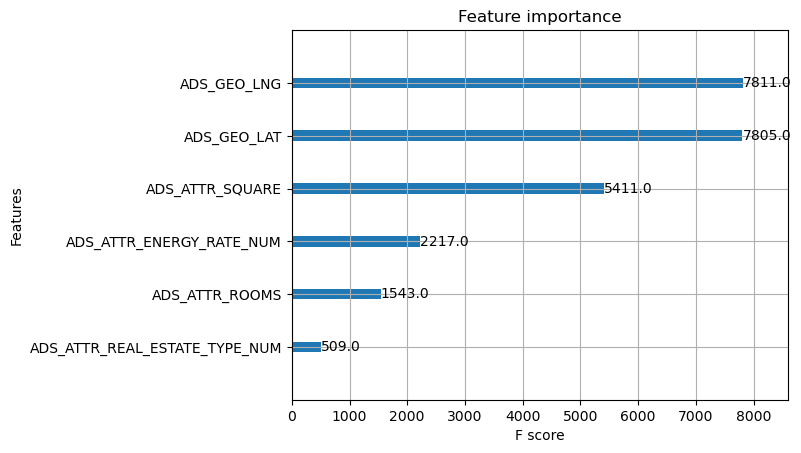

In [16]:
import matplotlib

xgb.plot_importance(bst)
from sklearn.metrics import explained_variance_score

pred_test = bst.predict(DMatrix_test)
print("pred_test : ", explained_variance_score(pred_test, DMatrix_test.get_label()))

![title](img/UC_5.png)

In [17]:
import cachetools


@cachetools.cached(cache={})
def load_xgboost_model(import_dir: str) -> object:
    import pandas
    import xgboost as xgb

    file_path = import_dir
    bst = xgb.Booster({"nthread": 0})  # init model
    bst.load_model(file_path)
    return xgb, bst

In [18]:
bst.save_model("./xgboost-model/RentPriceEstimation.xbmodel")
mySnowSess.sql(
    "put 'file:///Users/apicard/Documents/SnowFlake/Project/SnowParkPython/Project_1/Streamlit-realestate-LBC/xgboost-model/RentPriceEstimation.xbmodel' @UDF_PACKAGE_STAGE overwrite=true AUTO_COMPRESS = FALSE"
).collect()

dep_packages = [
    "pandas==1.3.5",
    "xgboost==1.5.0",
    "cachetools==4.2.2",
    "cloudpickle==2.0.0",
]
dep_imports = ["@UDF_PACKAGE_STAGE/RentPriceEstimation.xbmodel"]


@F.pandas_udf(
    name="get_PrixLocation_XGBoost",
    is_permanent=True,
    stage_location="@UDF_PACKAGE_STAGE",
    replace=True,
    max_batch_size=5000,
    imports=dep_imports,
    packages=dep_packages,
)
def get_PrixLocation_XGBoost(
    df: T.PandasDataFrame[float, float, float, float, float, float]
) -> T.PandasSeries[int]:
    import os
    import sys
    from pathlib import Path

    import pandas as pd

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    xgb, model = load_xgboost_model(import_dir + "RentPriceEstimation.xbmodel")
    rowDMatrix = xgb.DMatrix(df, enable_categorical=True)
    return model.predict(rowDMatrix)

![title](img/UC_6.png)
### On récupére les 10 appartements les plus rentables dans le departement 75 

In [19]:
mySnowSess.table("PETITES_ANNONCES_IMMOBILIRES.PUBLIC.LBC_ADS_JSON_DT").filter(
   (F.col("ADS")["category_name"].cast(T.StringType()) == "Ventes immobilières")
  & (F.col("ADS")["first_publication_date"].cast(T.TimestampType()) > F.current_date()-180)
  & (F.not_(F.is_null(F.col("ADS")["attribute"]["energy_rate"]["value_label"].cast(T.StringType()))))
).withColumn(
    "ADS_Estimated_Rent_Price",
    get_PrixLocation_XGBoost(
        F.col("ADS")["location"]["lat"].cast(T.DoubleType()),
        F.col("ADS")["location"]["lng"].cast(T.DoubleType()),
        F.col("ADS")["rooms"].cast(T.IntegerType()),
        F.col("ADS")["square"].cast(T.IntegerType()),
        UDF_Encode_TypeDeBien(F.col("ADS")["real_estate_type"].cast(T.StringType())),
        UDF_Encode_ClasseEnergie(F.col("ADS")["attribute"]["energy_rate"]["value_label"].cast(T.StringType())),
    ),
).select(
    F.col("ADS")["first_publication_date"].cast(T.TimestampType()).as_("ADS_First_Publication_Date"),
    F.col("ADS")["subject"].cast(T.StringType()).as_("ADS_Subject"),
    F.col("ADS")["price"].cast(T.IntegerType()).as_("ADS_Price"),
    F.col("ADS")["location"]["city"].cast(T.StringType()).as_("ADS_Geo_City"),
    F.col("ADS")["location"]["zipcode"].cast(T.StringType()).as_("ADS_Geo_ZipCode"),    
    F.col("ADS")["owner"]["type"].cast(T.StringType()).as_("ADS_Owner_Type"),
    F.col("ADS")["real_estate_type"].cast(T.StringType()).as_("ADS_Attr_Real_estate_type"),
    F.col("ADS")["rooms"].cast(T.IntegerType()).as_("ADS_Attr_Rooms"),
    F.col("ADS")["square"].cast(T.IntegerType()).as_("ADS_Attr_Square"),
    F.col("ADS")["attribute"]["ges"]["value_label"].cast(T.StringType()).as_("ADS_Attr_GES"),
    F.col("ADS")["attribute"]["energy_rate"]["value_label"].cast(T.StringType()).as_("ADS_Attr_Energy_Rate"),
    F.col("ADS_Estimated_Rent_Price"),
    (F.col("ADS_Price") / F.col("ADS_Attr_Square")).cast(T.IntegerType()).as_("ADS_PRICE_SQUARE"),
    (100 * (F.col("ADS_Estimated_Rent_Price") * 12) / F.col("ADS_Price")).cast(T.DoubleType()).as_("RENTABILITY"),
).sort(F.col("RENTABILITY"), ascending=False
).limit(10
).to_pandas()

,ADS_FIRST_PUBLICATION_DATE,ADS_SUBJECT,ADS_PRICE,ADS_GEO_CITY,ADS_GEO_ZIPCODE,ADS_OWNER_TYPE,ADS_ATTR_REAL_ESTATE_TYPE,ADS_ATTR_ROOMS,ADS_ATTR_SQUARE,ADS_ATTR_GES,ADS_ATTR_ENERGY_RATE,ADS_ESTIMATED_RENT_PRICE,ADS_PRICE_SQUARE,RENTABILITY
0,2024-01-21 13:36:44,Ferme à rénover,30000,Saint-Jean-d'Aubrigoux (43),43500,private,Maison,1,300,D,D,3225,100,129.000000
1,2024-01-14 13:53:08,Maison à rénover,15000,Anrosey (52),52500,private,Maison,2,196,Non renseigné,Non renseigné,1566,77,125.280000
2,2023-12-15 18:16:30,Maison à rénover,28000,Grenant (52),52500,private,Maison,5,360,Vierge,Vierge,2195,78,94.071429
3,2024-01-22 13:09:17,Maison ancien corps de ferme,28000,Grenant (52),52500,private,Maison,5,300,Non renseigné,Vierge,2195,93,94.071429
4,2024-02-15 16:35:19,Maison à rénover,50000,Lemainville (54),54740,private,Maison,7,300,Vierge,Vierge,2577,167,61.848000
5,2023-10-03 08:38:09,Maison ancienne à rénover,50000,Lemainville (54),54740,private,Maison,7,300,Vierge,Vierge,2577,167,61.848000
6,2024-03-12 14:43:01,Maison à rénover,50000,Lemainville (54),54740,private,Maison,7,300,Vierge,Vierge,2577,167,61.848000
7,2024-03-15 08:24:00,Maison 4 pièces 96 m²,12990,Dommartin-le-Franc (52),52110,pro,Maison,4,96,G,G,651,135,60.138568
8,2023-12-11 07:27:00,Maison 4 pièces 96 m²,12999,Dommartin-le-Franc (52),52110,pro,Maison,4,96,G,G,651,135,60.096931
9,2023-11-27 09:50:00,Maison 4 pièces 90 m²,13500,Lacaze (81),81330,pro,Maison,4,90,Non renseigné,Non renseigné,645,150,57.333333


### On applique la fonction de calcul du prix de location à toutes les annonces

In [20]:
SnowDataFrame_AnnonceVenteRentabilite = mySnowSess.table("PETITES_ANNONCES_IMMOBILIRES.PUBLIC.LBC_ADS_JSON_DT").filter(
    (F.col("ADS")["category_name"].cast(T.StringType()) == "Ventes immobilières")
  & (F.col("ADS")["attribute"]["immo_sell_type"]["value_label"].cast(T.StringType()) == "old")
  & (F.col("ADS")["attribute"]["lease_type"]["value_label"].cast(T.StringType()) == "sell")
  & (F.col("ADS")["first_publication_date"].cast(T.TimestampType()) > F.current_date()-365)    
  & (F.not_(F.is_null(F.col("ADS")["attribute"]["energy_rate"]["value_label"].cast(T.StringType()))))
).withColumn(
    "ESTIMATED RENT PRICE",
    get_PrixLocation_XGBoost(
        F.col("ADS")["location"]["lat"].cast(T.DoubleType()),
        F.col("ADS")["location"]["lng"].cast(T.DoubleType()),
        F.col("ADS")["rooms"].cast(T.IntegerType()),
        F.col("ADS")["square"].cast(T.IntegerType()),
        UDF_Encode_TypeDeBien(F.col("ADS")["real_estate_type"].cast(T.StringType())),
        UDF_Encode_ClasseEnergie(F.col("ADS")["attribute"]["energy_rate"]["value_label"].cast(T.StringType())),
    ),
).select(
    F.col("ADS"),
    F.col("ADS")["location"]["codeinsee"].cast(T.StringType()).as_("CODEINSEE"),        
    F.col("ESTIMATED RENT PRICE"),
)


In [21]:
SnowDataFrame_GeoInsee = mySnowSess.table("INSEE_BASE_DU_COMPARATEUR_DE_TERRITOIRES_FRANCE.PUBLIC.COMMUNE").select(
        F.col("CODEINSEE"),
        F.col("ARRONDISSEMENT"),
        F.col("DEPARTEMENT_CODE"),
        F.col("DEPARTEMENT"),
        F.col("STATEPROVINCE").as_("REGION"),
        F.col("ARRONDISSEMENT_LATITUDE"),
        F.col("ARRONDISSEMENT_LONGITUDE"),
        F.col("LATITUDE").as_("CITY_LATITUDE"),
        F.col("LONGITUDE").as_("CITY_LONGITUDE"),
)
SnowDataFrame_GeoInsee.limit(10
).to_pandas()

,CODEINSEE,ARRONDISSEMENT,DEPARTEMENT_CODE,DEPARTEMENT,REGION,ARRONDISSEMENT_LATITUDE,ARRONDISSEMENT_LONGITUDE,CITY_LATITUDE,CITY_LONGITUDE
0,67532,Saverne,67,Bas-Rhin (67),Grand Est,48.796207,7.406644,48.672404,7.513365
1,67535,Saverne,67,Bas-Rhin (67),Grand Est,48.796207,7.406644,48.918751,7.426552
2,67552,Saverne,67,Bas-Rhin (67),Grand Est,48.796207,7.406644,48.877553,7.083358
3,63020,Clermont-Ferrand,63,Puy-de-Dôme (63),Auvergne-Rhône-Alpes,45.732895,3.070666,45.677402,2.918222
4,63032,Clermont-Ferrand,63,Puy-de-Dôme (63),Auvergne-Rhône-Alpes,45.732895,3.070666,45.749898,3.088175
5,63053,Clermont-Ferrand,63,Puy-de-Dôme (63),Auvergne-Rhône-Alpes,45.732895,3.070666,45.705550,2.632118
6,63063,Clermont-Ferrand,63,Puy-de-Dôme (63),Auvergne-Rhône-Alpes,45.732895,3.070666,45.829710,3.104103
7,63065,Clermont-Ferrand,63,Puy-de-Dôme (63),Auvergne-Rhône-Alpes,45.732895,3.070666,45.656465,3.516577
8,63069,Clermont-Ferrand,63,Puy-de-Dôme (63),Auvergne-Rhône-Alpes,45.732895,3.070666,45.718457,3.187947
9,63084,Clermont-Ferrand,63,Puy-de-Dôme (63),Auvergne-Rhône-Alpes,45.732895,3.070666,45.690345,3.097332


In [22]:
SnowDataFrame_AnnonceVenteRentabilite_WithGeo = SnowDataFrame_AnnonceVenteRentabilite.join(
    SnowDataFrame_GeoInsee,
    (
        SnowDataFrame_AnnonceVenteRentabilite.col("CODEINSEE")
        == SnowDataFrame_GeoInsee.col("CODEINSEE")
    )
).select(
    F.col("ADS")["list_id"].cast(T.IntegerType()).as_("ID"),
    F.col("ADS")["first_publication_date"].cast(T.TimestampType()).as_("DATE"),
    F.col("ADS")["category_name"].cast(T.StringType()).as_("CATEGORY NAME"),
#    F.col("ADS")["expiration_date"].cast(T.TimestampType()).as_("EXPIRATION DATE"),
    F.col("ADS")["has_phone"].cast(T.BooleanType()).as_("HAS PHONE"),
#    F.col("ADS")["index_date"].cast(T.TimestampType()).as_("INDEX DATE"),
    F.col("ADS")["subject"].cast(T.StringType()).as_("SUBJECT"),
    F.col("ADS")["body"].cast(T.StringType()).as_("BODY"),          
    F.col("ADS")["price"].cast(T.IntegerType()).as_("PRICE"),
    F.col("ADS")["square"].cast(T.IntegerType()).as_("SQUARE"),
    F.col("ADS")["rooms"].cast(T.IntegerType()).as_("ROOMS"),
    F.col("ADS")["real_estate_type"].cast(T.StringType()).as_("REAL ESTATE TYPE"),
    F.col("ADS")["link_url"].cast(T.StringType()).as_("URL"),
    F.col("ADS")["images_url"].cast(T.StringType()).as_("IMAGE URL"),
    F.col("ADS")["location"]["city"].cast(T.StringType()).as_("CITY"),
    F.col("ADS")["location"]["zipcode"].cast(T.StringType()).as_("ZIPCODE"),    
    F.col("ADS")["location"]["codeinsee"].cast(T.StringType()).as_("CODEINSEE"),    
    F.col("ADS")["location"]["lat"].cast(T.DoubleType()).as_("LATITUDE"),
    F.col("ADS")["location"]["lng"].cast(T.DoubleType()).as_("LONGITUDE"),    
    F.col("ADS")["options"]["urgent"].cast(T.BooleanType()).as_("URGENT"),
    F.col("ADS")["owner"]["type"].cast(T.StringType()).as_("OWNER TYPE"),
    F.col("ADS")["owner"]["name"].cast(T.StringType()).as_("OWNER"),
    F.col("ADS")["attribute"]["ges"]["value_label"].cast(T.StringType()).as_("GES"),
    F.col("ADS")["attribute"]["energy_rate"]["value_label"].cast(T.StringType()).as_("ENERGY RATE"),
 #   F.col("ADS")["attribute"]["fai_included"]["value_label"].cast(T.StringType()).as_("FAI INCLUDED"),
 #   F.col("ADS")["attribute"]["charges_included"]["value_label"].cast(T.StringType()).as_("CHARGES INCLUDED"),
 #   F.col("ADS")["attribute"]["furnished"]["value_label"].cast(T.StringType()).as_("FURNISHED"),
 #   F.col("ADS")["attribute"]["lease_type"]["value_label"].cast(T.StringType()).as_("LEASE TYPE"),
 #   F.col("ADS")["attribute"]["immo_sell_type"]["value_label"].cast(T.StringType()).as_("IMMO SELL TYPE"),
    F.col("ADS")["attribute"]["bedrooms"]["value_label"].cast(T.StringType()).as_("BEDROOMS"),
    F.col("ADS")["attribute"]["mandate_type"]["value_label"].cast(T.StringType()).as_("MANDATE TYPE"),
    F.col("ADS")["attribute"]["floor_number"]["value_label"].cast(T.StringType()).as_("FLOOR NUMBER"),
    F.col("ADS")["attribute"]["elevator"]["value_label"].cast(T.StringType()).as_("ELEVATOR"),
    F.col("ADS")["attribute"]["nb_parkings"]["value_label"].cast(T.StringType()).as_("NB PARKINGS"),
    F.col("ADS")["attribute"]["old_price"]["value_label"].cast(T.StringType()).as_("OLD PRICE"),
    F.col("ADS")["attribute"]["nb_floors_building"]["value_label"].cast(T.StringType()).as_("NB FLOORS BUILDING"),
    F.col("ADS")["attribute"]["outside_access"]["value_label"].cast(T.StringType()).as_("OUTSIDE ACCESS"),
    F.col("ADS")["attribute"]["nb_floors_house"]["value_label"].cast(T.StringType()).as_("NB FLOORS HOUSE"),
    F.col("ADS")["attribute"]["type_real_estate_sale"]["value_label"].cast(T.StringType()).as_("TYPE REAL ESTATE SALE"),
    F.col("ESTIMATED RENT PRICE"),
    F.col("ARRONDISSEMENT"),
    F.col("DEPARTEMENT_CODE"),
    F.col("DEPARTEMENT"),
    F.col("REGION"),
    F.col("ARRONDISSEMENT_LATITUDE"),
    F.col("ARRONDISSEMENT_LONGITUDE"),
    F.col("CITY_LATITUDE"),
    F.col("CITY_LONGITUDE"),
    (F.col("PRICE") / F.col("SQUARE")).cast(T.IntegerType()).as_("PRICE PER SQUARE METER"),
    (100 * (F.col("ESTIMATED RENT PRICE") * 12) / F.col("PRICE")).cast(T.DoubleType()).as_("RENTABILITY"),
)

SnowDataFrame_AnnonceVenteRentabilite_WithGeo.limit(10
).to_pandas()


,ID,DATE,CATEGORY NAME,HAS PHONE,SUBJECT,BODY,PRICE,SQUARE,ROOMS,REAL ESTATE TYPE,...,ARRONDISSEMENT,DEPARTEMENT_CODE,DEPARTEMENT,REGION,ARRONDISSEMENT_LATITUDE,ARRONDISSEMENT_LONGITUDE,CITY_LATITUDE,CITY_LONGITUDE,PRICE PER SQUARE METER,RENTABILITY
0,2384610516,2023-07-25 08:52:00,Ventes immobilières,True,Appartement 4 pièces 67 m²,Appartement 4 pièces 67 m²\n\nA VENDRE - Quart...,335000,67,4,Appartement,...,Nanterre,92,Hauts-de-Seine (92),Île-de-France,48.902835,2.254474,48.868729,2.176224,5000,5.437612
1,2517409935,2024-02-26 21:00:20,Ventes immobilières,False,Quartier MICHELET - Maison mitoyenne de type 4,"A vendre, quartier MICHELET -\n\nEn impasse, m...",305000,85,4,Maison,...,Aix-en-Provence,13,Bouches-du-Rhône (13),Provence-Alpes-Côte d'Azur,43.473901,5.407269,43.654620,5.094828,3588,4.835410
2,2484875183,2024-01-27 20:56:39,Ventes immobilières,True,"Appartement avec jardin et garages , achat pos...","À la Terrasse Saint-Étienne, appartement actue...",290000,188,6,Appartement,...,Saint-Étienne,42,Loire (42),Auvergne-Rhône-Alpes,45.417944,4.489197,45.439123,4.395362,1543,6.463448
3,2517750140,2024-02-26 21:01:00,Ventes immobilières,True,Villa 4 pièces 69 m²,Villa 4 pièces 69 m²\n\nImmobilier.notaires® e...,129600,69,4,Maison,...,Nancy,54,Meurthe-et-Moselle (54),Grand Est,48.691419,6.223633,48.836537,6.054779,1878,6.620370
4,2604981415,2024-03-19 14:02:00,Ventes immobilières,True,Appartement 4 pièces 95 m²,Vente Appartement 4 pièces\n\niad France - Sté...,520000,95,4,Appartement,...,Créteil,94,Val-de-Marne (94),Île-de-France,48.768390,2.446521,48.797051,2.496215,5474,4.723846
5,2616547307,2024-03-28 15:50:04,Ventes immobilières,True,Villa contemporaine Cavalaire,maison contemporaine récente 2013 sans vis à v...,1195000,180,7,Maison,...,Draguignan,83,Var (83),Provence-Alpes-Côte d'Azur,43.512415,6.527310,43.179481,6.519969,6639,3.360000
6,2608394951,2024-03-22 13:45:00,Ventes immobilières,True,Maison 8 pièces 124 m²,Vente Maison/villa 8 pièces\n\niad France - Cl...,258000,124,8,Maison,...,Arras,62,Pas-de-Calais (62),Hauts-de-France,50.245688,2.869897,50.235323,2.972405,2081,4.400000
7,2608404878,2024-03-22 11:12:00,Ventes immobilières,True,Appartement 1 pièce 19 m²,NANTES - Appartement Nantes 1 pièce(s) 19m²\n\...,76300,19,1,Appartement,...,Nantes,44,Loire-Atlantique (44),Pays de la Loire,47.186993,-1.646051,47.225279,-1.553166,4016,7.973788
8,2603801666,2024-03-18 15:22:00,Ventes immobilières,True,Maison 6 pièces 174 m²,Maison 6 pièces 174 m²\n\nLA CHAUSSEE D'IVRY (...,399000,174,6,Maison,...,Dreux,28,Eure-et-Loir (28),Centre-Val de Loire,48.633337,1.165598,48.889152,1.477906,2293,3.849624
9,2608984608,2024-03-23 09:15:00,Ventes immobilières,True,Maison 5 pièces 253 m²,Vente Maison/villa 5 pièces\n\niad France - An...,468000,253,5,Maison,...,Saint-Lô,50,Manche (50),Normandie,49.087452,-1.091010,49.029209,-1.220481,1850,4.038462


In [23]:
SnowDataFrame_AnnonceVenteRentabilite_WithGeo.write.mode(
    "overwrite"
).saveAsTable(
    "REALESTATE_DB.GOLD.ADS"
)

@F.sproc(name="RENTABILITY_INFERENCE", is_permanent=True, stage_location="@REAL_ESTATE_DATA", replace=True, packages=["snowflake-snowpark-python","cachetools"])
def RENTABILITY_INFERENCE(session: Session) -> int:
    session.table("ANNONCEIMMO_DB.GOLD.ANNONCES_IMMOBILIERE_ENRICH").filter(
    (F.col("ADS_CATEGORY_NAME") == "Ventes immobilières")
).withColumn(
    "ESTIMATEDRENTPRICE",
    F.call_builtin("SNOWPARKDEMO_DB.DATASCIENCE.GET_PRIXLOCATION_XGBOOST",
        F.col("ADS_GEO_LAT"),
        F.col("ADS_GEO_LNG"),
        F.col("ADS_ATTR_ROOMS"),
        F.col("ADS_ATTR_SQUARE"),
        F.call_builtin("SNOWPARKDEMO_DB.DATASCIENCE.UDF_ENCODE_TYPEDEBIEN_SNOW",F.col("ADS_ATTR_REAL_ESTATE_TYPE")),
        F.call_builtin("SNOWPARKDEMO_DB.DATASCIENCE.UDF_ENCODE_CLASSEENERGIE",F.col("ADS_ATTR_ENERGY_RATE")))
).withColumn(
    "RENTABILITY", 100 * (F.col("ESTIMATEDRENTPRICE") * 12) / F.col("ADS_PRICE")
).withColumn(
    "ADS_PRICE_SQUARE", (F.col("ADS_PRICE") / F.col("ADS_ATTR_SQUARE"))
).write.mode(
    "overwrite"
).saveAsTable(
    "ANNONCES_VENTES_RENTABILITY"
)
    return 1
